In [17]:
# aim of this notebook: get MLE working on some sort of exponential * sine combination. (no PSD just yet)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
%matplotlib inline

def log_likelihood(func, data):
    def get_ll(pars):
        pars_model, sd = pars[:len(pars)-1], pars[-1]
        data_predicted = func(pars_model)
        LL = -np.sum(norm.logpdf(data, loc=data_predicted, scale=sd))
        return LL
    return get_ll

def get_pars_mle(func, data_actual, pars_init):
    ll = log_likelihood(func, data_actual)
    results = minimize(ll, pars_init, method='L-BFGS-B')
    return results.x

def get_data_model(func, pars_mle):
    return func(pars_mle[:-1])

Actual parameters: [0.31903341592037626, 52.93838509390142, 9.674746190089422e-05, 4.680421365356288]
Maximum-likelihood estimated parameters: [  2.30663315 175.00100197   1.67006869   6.15890511]
SD of fit: 0.22209181274199843


/Users/adityasengupta/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/adityasengupta/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1762: RuntimeWarning: overflow encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/adityasengupta/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:166: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/Users/adityasengupta/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


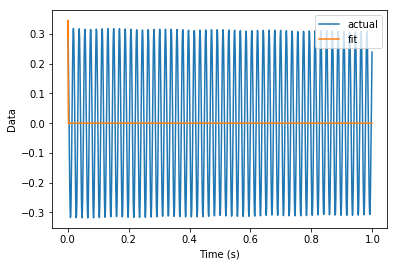

In [18]:
f_sampling = 1000
times = np.arange(0, 1, 1/f_sampling)
A = np.random.uniform(low=0.1, high=1) #mas
f = np.random.uniform(low=f_sampling/60, high=f_sampling/3) #Hz
k = np.random.uniform(low=0.00001, high=0.0001) # unitless
p = np.random.uniform(low=0, high=2*np.pi) # rad
pars_actual = [A, f, k, p]
pars_guess = [0.55, 0.175*f_sampling, 0.00055, np.pi, 0.2]
#bounds = [(0.01, 1), (0.1, 1000), (0.00001, 0.001), (0, 2*np.pi), (0, None)]

def damped_harmonic(pars_model):
    A, f, k, p = pars_model
    return A * np.exp(-k*2*np.pi*f*times) * np.sin(2*np.pi*f*times - p)

data_dh = damped_harmonic(pars_actual)
pars_mle = get_pars_mle(damped_harmonic, data_dh, pars_guess)
data_model = get_data_model(damped_harmonic, pars_mle)

print("Actual parameters: " + str(pars_actual))
print("Maximum-likelihood estimated parameters: " + str(pars_mle[:-1]))
print("SD of fit: " + str(pars_mle[-1]))
plt.plot(times, data_dh, label='actual')
plt.plot(times, data_model, label='fit')
plt.xlabel("Time (s)")
plt.ylabel("Data")
plt.legend()

Text(0,0.5,'Data residual')

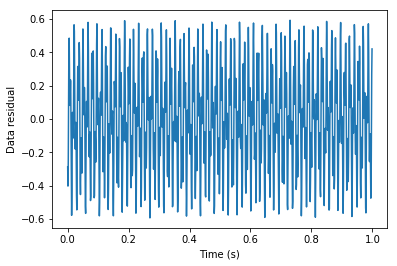

In [13]:
plt.plot(times, data_model-data_dh, label='residual')
plt.xlabel("Time (s)")
plt.ylabel("Data residual")

In [ ]:
# okay...now for the same thing but with PSD fitting

from scipy.signal import periodogram

def psd(pars_model):
    return periodogram(damped_harmonic(pars_model), fs=f_sampling)[1]

freqs = periodogram(damped_harmonic(pars_init[:-1]), fs=f_sampling)[0]
data_psd = psd(pars_actual)
psd_ll = log_likelihood(psd, data_psd)

results = minimize(psd_ll, pars_init, method='Nelder-Mead')
data_model = psd(results.x[:-1])
print(results.x)
plt.semilogy(freqs, data_model, label='fit')
plt.semilogy(freqs, data_psd, label='actual')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Data")
plt.legend()

In [ ]:
residual = np.abs(data_model - data_psd)